In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_4378.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_747.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_561.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_345.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_3019.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_2566.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_3156.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_3889.jpg
/kaggle/input/human-action-recognition-har-dataset

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import StandardScaler
from torchvision import transforms
from PIL import Image
from skimage import filters
import cv2

In [14]:
# Load dataset paths
train_path = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train"
test_path = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test"
train_csv_path = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv"
test_csv_path = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv"

In [15]:
# Load CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [4]:
# Presenting the Raw Dataset and Dataset Description
print("First few rows of the dataset:")
display(train_df.head())
print("\nDataset Description:")
print(f"Number of records: {train_df.shape[0]}")
print(f"Number of features: {train_df.shape[1]}")
print("\nData Types:")
print(train_df.dtypes)
print("\nMissing Values Count:")
print(train_df.isnull().sum())


First few rows of the dataset:


filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop


Dataset Description:
Number of records: 12600
Number of features: 2

Data Types:
filename    object
label       object
dtype: object

Missing Values Count:
filename    0
label       0
dtype: int64


In [9]:
print(f"Duplicate rows: {train_df.duplicated().sum()}")
train_df = train_df.drop_duplicates()

Duplicate rows: 0


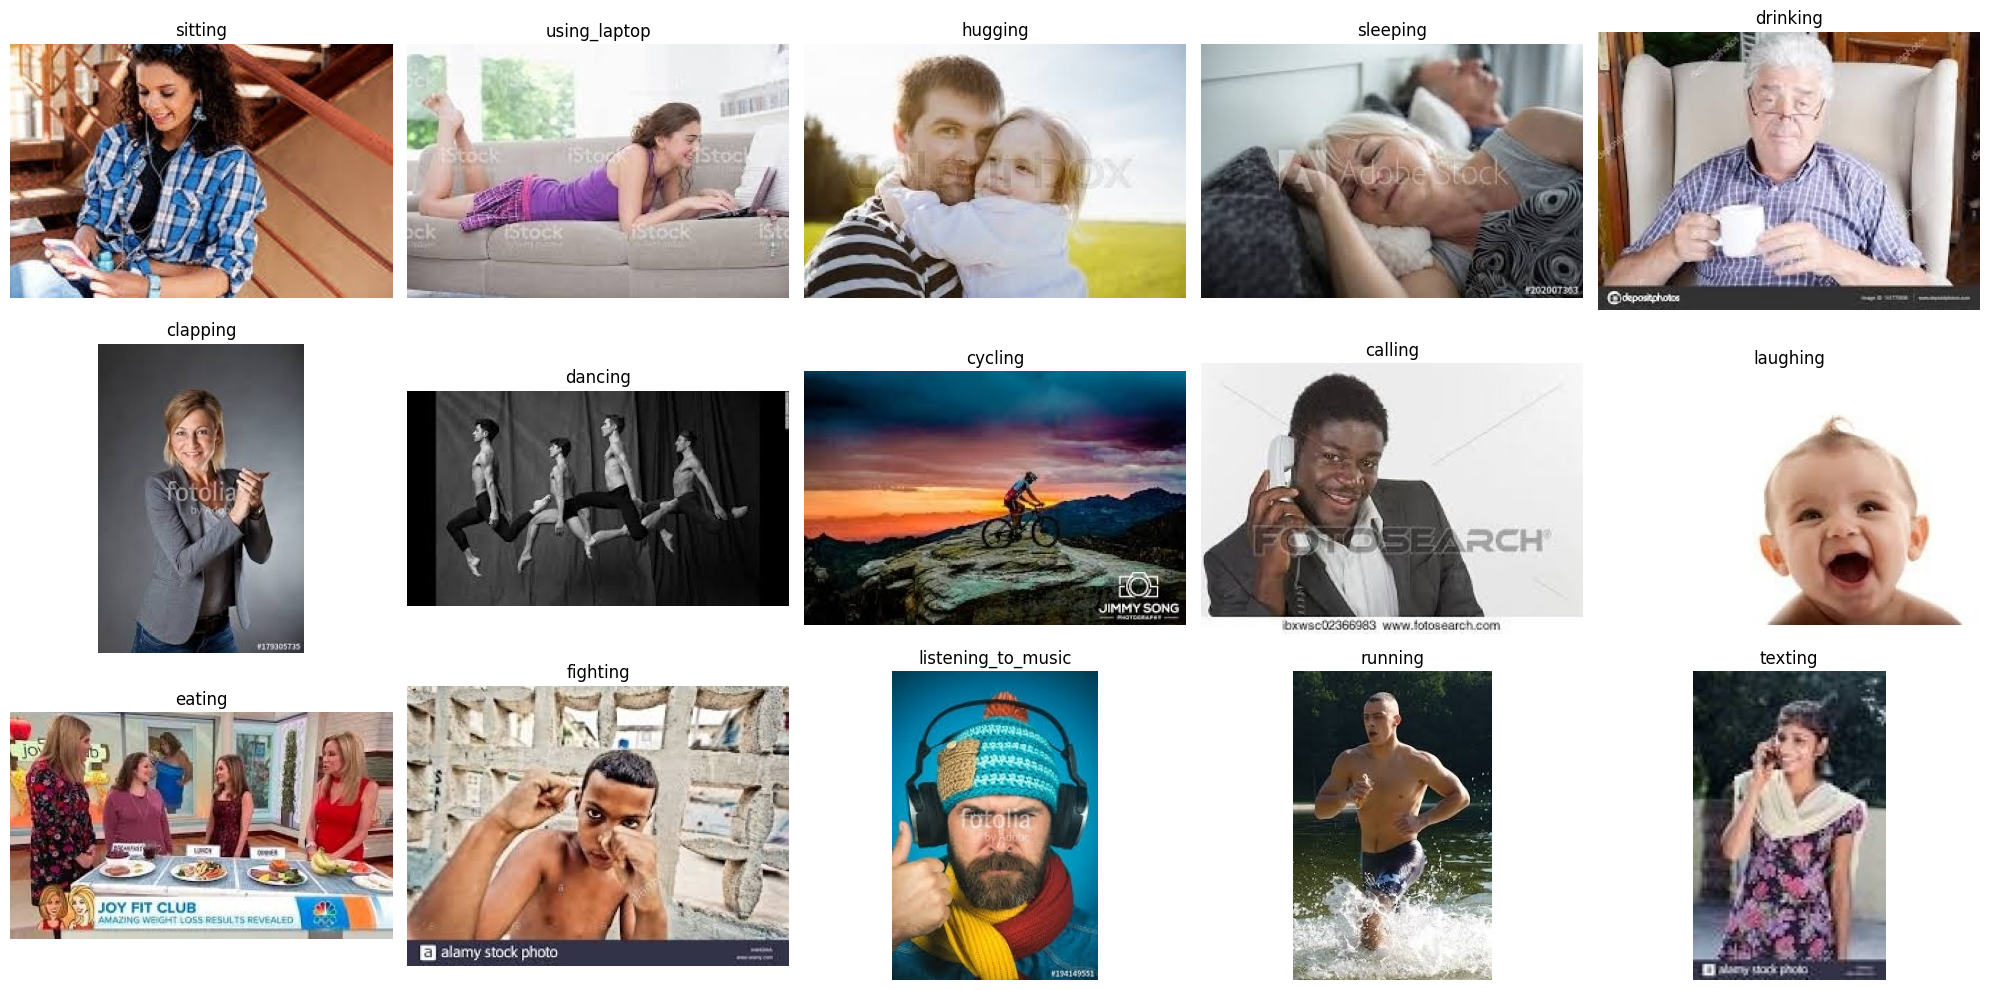

In [7]:
# Images from each class
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()
for idx, class_name in enumerate(train_df['label'].unique()):
    class_images = train_df[train_df['label'] == class_name]['filename'].values
    img = plt.imread(os.path.join(train_path, class_images[0]))
    axes[idx].imshow(img)
    axes[idx].set_title(class_name)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Distribution of classes in training set
fig = px.histogram(train_df, x='label', title='Distribution of Classes in Training Set')
fig.show()

**No Imbalance in dataset**

In [27]:
# Statistical summary
print(train_df.describe())

# Select only numerical columns for outlier detection
numerical_columns = X_df.select_dtypes(include=['int64', 'float64']).columns
numerical_data = X_df[numerical_columns]


# Outlier detection using z-score method
from scipy.stats import zscore

# Compute z-scores for numerical data only
z_scores = np.abs(zscore(numerical_data))
outliers = (z_scores > 3).sum(axis=1)  # Counts how many features are outliers for each row
print(f"Number of rows with outliers: {np.sum(outliers > 0)}")


           filename    label
count         12600    12600
unique        12600       15
top     Image_1.jpg  sitting
freq              1      840
Number of rows with outliers: 0


In [47]:
from scipy.stats import zscore
import scipy.stats as stats
import numpy as np

def z_score_outlier_detection(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    outliers = np.where(z_scores > threshold)[0]  # Extract indices
    return outliers

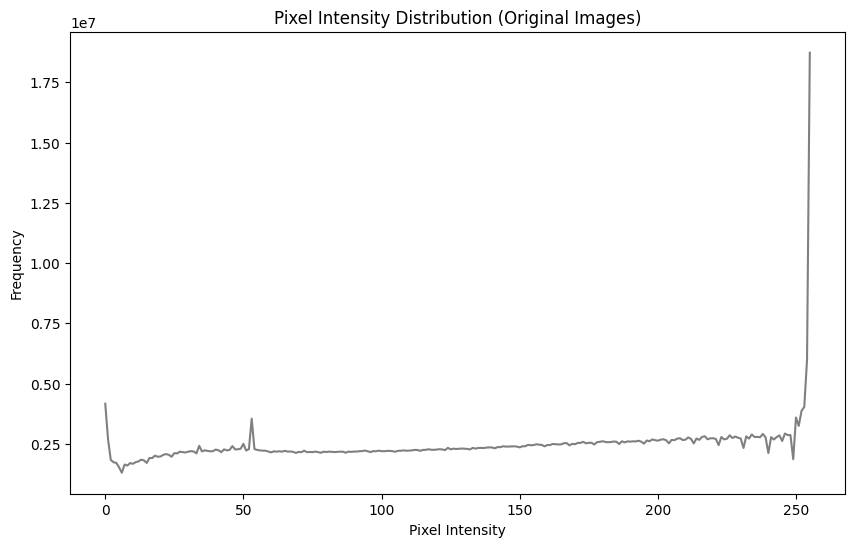

In [17]:
# Initialize histogram array (for 256 bins)
histogram = np.zeros(256, dtype=int)

# To store mean intensity per image for outlier detection (if needed)
image_means = []  

# Loop through images to collect pixel intensities
for image_name in os.listdir(train_path):
    # Load image in grayscale for pixel intensity analysis
    image = Image.open(os.path.join(train_path, image_name)).convert('L')  # Convert to grayscale
    image_array = np.array(image)
    
    # Incrementally update histogram
    hist, _ = np.histogram(image_array, bins=256, range=(0, 255))
    histogram += hist
    
    # Store the mean intensity for each image (optional)
    image_means.append(image_array.mean())

# Plot the overall pixel intensity distribution
plt.figure(figsize=(10, 6))
plt.plot(histogram, color='gray')
plt.title("Pixel Intensity Distribution (Original Images)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()



Overall Shape:

The histogram is skewed to the right, indicating that the majority of pixels in the images have lower intensity values.
There's a sharp peak around pixel intensity 250, suggesting a significant number of pixels are at the maximum intensity level.


Notable Features:

Low-Intensity Region: The histogram shows a relatively flat region in the lower intensity range (0-50). This indicates a consistent distribution of pixels with low intensity values.
Mid-Intensity Region: There's a slight increase in the histogram's height between intensity values 50 and 150, suggesting a moderate number of pixels in this range.
High-Intensity Peak: The sharp peak around intensity 250 indicates a large number of pixels at the maximum intensity level. This could be due to various factors, such as:



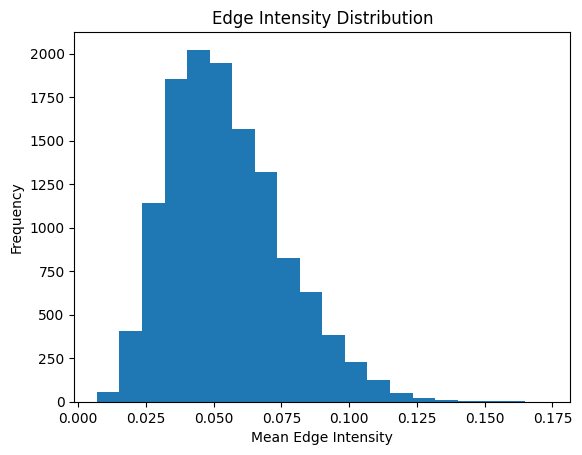

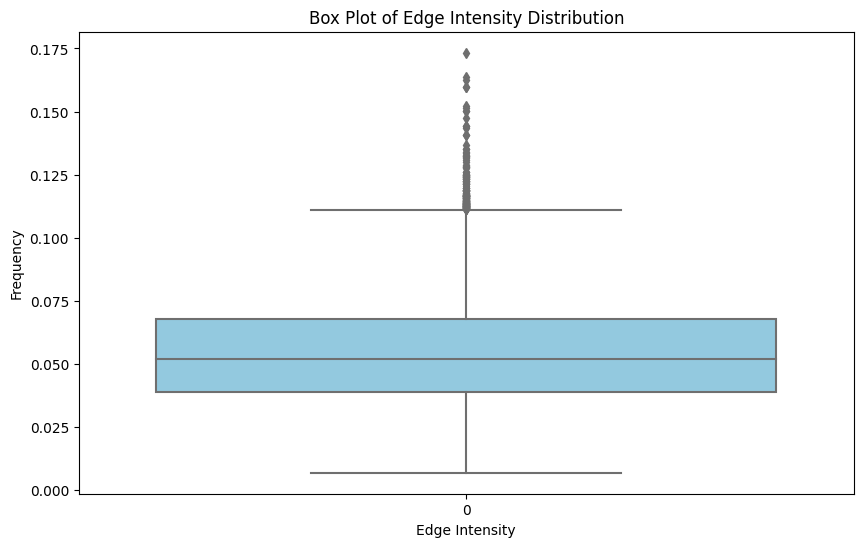

In [44]:
from skimage import filters
import numpy as np

#  Extract edge intensity histograms
edge_intensity_list = []

for image_name in os.listdir(train_path):
    image = Image.open(os.path.join(train_path, image_name)).convert('L')
    edges = filters.sobel(np.array(image))  # Apply edge detection
    edge_intensity_list.append(np.mean(edges))  # Calculate mean edge intensity for each image

# Plot edge intensity distribution
plt.hist(edge_intensity_list, bins=20)
plt.title("Edge Intensity Distribution")
plt.xlabel("Mean Edge Intensity")
plt.ylabel("Frequency")
plt.show()

# Box plot for edge intensity distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=edge_intensity_list, color='skyblue')
plt.title("Box Plot of Edge Intensity Distribution")
plt.xlabel("Edge Intensity")
plt.ylabel("Frequency")
plt.show()


The distribution is right-skewed, with most images having a mean edge intensity around 0.025 to 0.05.
As the mean edge intensity increases beyond 0.075, the frequency of images with higher intensities gradually decreases.
Very few images have a high mean edge intensity above 0.1, which could indicate fewer images with strong or prominent edges in the dataset.
This suggests that the majority of images in this dataset have relatively low to moderate edge intensity, indicating they likely contain smooth or less textured regions.
The images with higher edge intensities might contain more complex textures or sharp transitions, such as objects with distinct outlines or fine details.

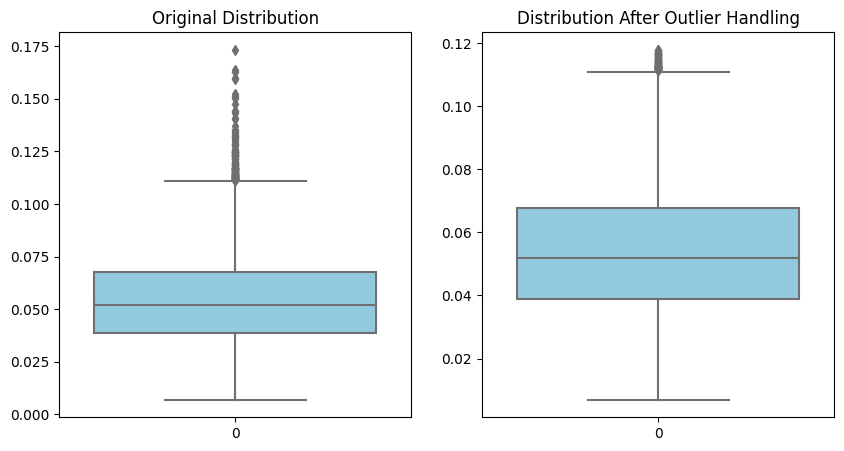

In [48]:
# Visualize the distribution before and after outlier handling
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=edge_intensity_list, color='skyblue')
plt.title("Original Distribution")

# Detect outliers using Z-score method
outliers = z_score_outlier_detection(edge_intensity_list)

# Cap outliers to a reasonable value (99th percentile)
percentile_99 = np.percentile(edge_intensity_list, 99)
for i in outliers:
    edge_intensity_list[i] = min(edge_intensity_list[i], percentile_99)



plt.subplot(1, 2, 2)
sns.boxplot(data=edge_intensity_list, color='skyblue')
plt.title("Distribution After Outlier Handling")

plt.show()

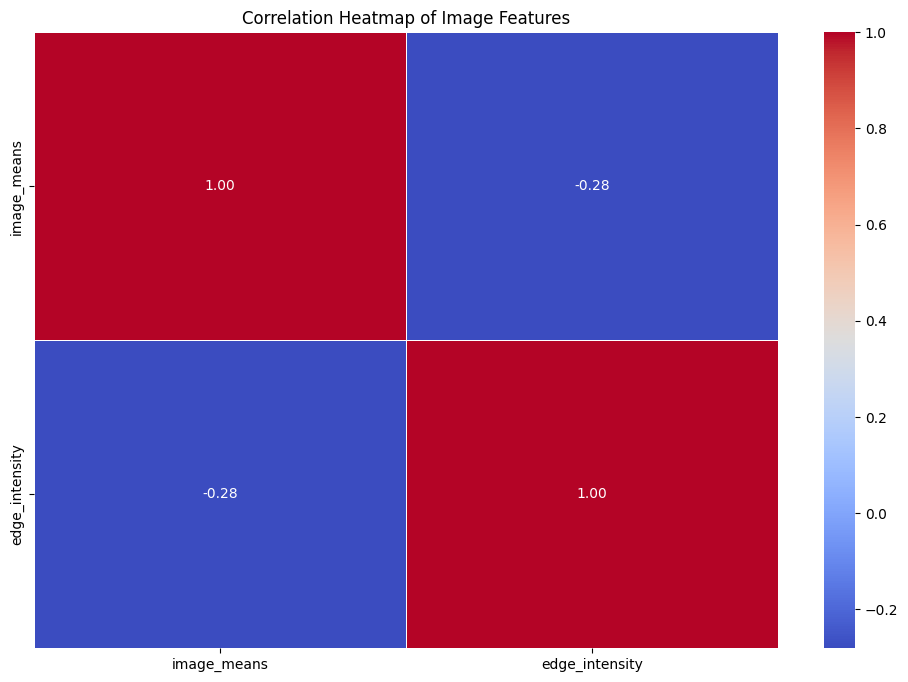

In [49]:
# Convert the list of histograms to a DataFrame
image_means_df = pd.DataFrame(image_means, columns=['image_means'])

# edge intensity
edge_intensity_df = pd.DataFrame(edge_intensity_list, columns=['edge_intensity'])
df_features = pd.concat([image_means_df, edge_intensity_df], axis=1)

# Calculate correlation matrix
correlation_matrix = df_features.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Image Features")
plt.show()

no relation between edge intensity and image-means

In [38]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, data_frame, img_dir, transform=None):
        self.data_frame = data_frame
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx, 0]  # Assuming the first column has image names
        label = self.data_frame.iloc[idx, 1]     # Assuming the second column has labels
        img_path = os.path.join(self.img_dir, img_name)
        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [36]:
# data augmentation to provide diversity
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
   #these are the mean and deviation that are most ideal when interacting with image data
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [40]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df['filename'], train_df['label'], test_size=0.2, random_state=42)

# Combine filenames and labels into DataFrames
train_data = pd.DataFrame({'filename': X_train, 'label': y_train}).reset_index(drop=True)
val_data = pd.DataFrame({'filename': X_val, 'label': y_val}).reset_index(drop=True)

# Initialize the dataset with transformations for the training set only
train_dataset = CustomImageDataset(data_frame=train_data, img_dir=train_path, transform=train_transform)
val_dataset = CustomImageDataset(data_frame=val_data, img_dir=train_path, transform=None)  # No transform for validation

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

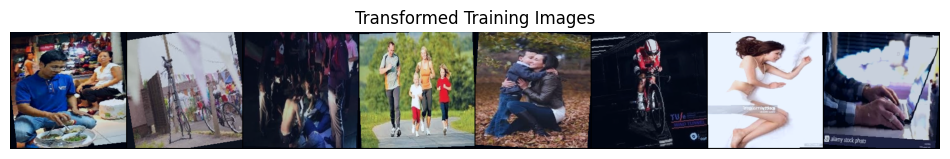

In [41]:
# Verify by visualizing a batch of transformed images
import torchvision.utils as vutils

data_iter = iter(train_loader)
images, labels = next(data_iter)  # Use next() function here

plt.figure(figsize=(12,8))
plt.axis("off")
plt.title("Transformed Training Images")
plt.imshow(np.transpose(vutils.make_grid(images[:8], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()
